In [1]:
import level1,level2,analysis,plottools,inversions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import datetime as dt
import scipy.stats as stats
import numpy.ma as ma
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as sciopt
import matplotlib.tri as tri

In [2]:
# Data
eddies = np.load('../../eddies_last.npy').item()
ADCPs = np.load('../../ADCPS.npy').item()

# Eddy model

## The Rankine vortex
In this work, we approximate the eddies by Rankine vortices defined by a core in solid body rotation (SBR) until a typical radius R where it reaches its maximum velocity V and then decays with $1/r$ :
$$
\tilde{v}(r) = \left\{
            \begin{array}{r l}
                \frac{Vr}{R} & \text{when } r \leq R \\
                \frac{VR}{r} & \text{when } r \gt R
            \end{array}
            \right.
$$

In [3]:
# Center coordinates
xc = 0
yc = 0
# Rankine parameters
cR = 50
mV = 0.5

### Cross section of a Rankine vortex going through the center

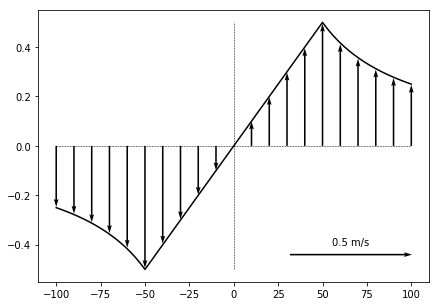

In [7]:
# Space
r = np.arange(-100,101,1)
r2 = np.arange(-100,110,10)
# Simulation
mv = inversions.Rankine(r,cR,mV)
mv2 = inversions.Rankine(r2,cR,mV)
# Figure
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
# Plot
ax.plot(r,mv,'k-')
ax.plot([-100,100],[0,0],'k--',linewidth=0.5)
ax.plot([0,0],[-0.5,0.5],'k--',linewidth=0.5)
Q = ax.quiver(r2,np.zeros(len(r2)),np.zeros(len(r2)),mv2,width=0.004,scale=1.6)
ax.quiverkey(Q,0.8,0.1,0.5,label= '0.5 m/s')
plt.show()

### 2D representation of a Rankine vortex

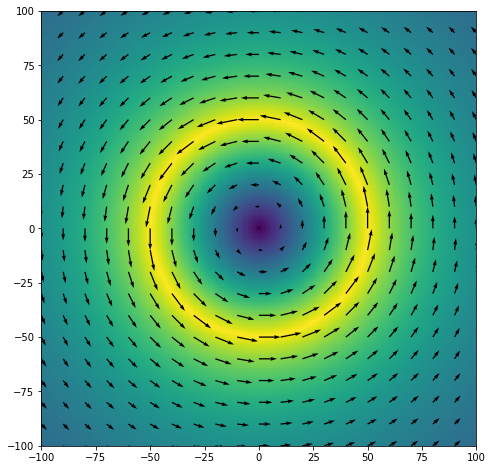

In [6]:
# Fine space
xx = np.arange(-100,101,1)
yy = np.arange(-100,101,1)
XX,YY = np.meshgrid(xx,yy)
# Coarse space
xx2 = np.arange(-100,110,10)
yy2 = np.arange(-100,110,10)
XX2,YY2 = np.meshgrid(xx2,yy2)
# Absolute velocities of fine space
angles,norms = inversions.SimulateRankine(XX,YY,xc,yc,cR,mV,fmt='AN')
# U and V on coarse space
rrU,rrV = inversions.SimulateRankine(XX2,YY2,xc,yc,cR,mV,fmt='UV')
# Figure setup
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_aspect('equal')
ax.set_ylim(-100,100)
ax.set_xlim(-100,100)
# Plots
ax.pcolormesh(XX,YY,norms)
ax.quiver(xx2,yy2,rrU,rrV,width=0.003,pivot='tail',scale=10)

plt.show()

# ADCP data analysis for eddy center detection

In [8]:
# Data import
eddy = 'V1'
U = eddies[eddy]['U']
V = eddies[eddy]['V']
U_filt = eddies[eddy]['U reg filt']
V_filt = eddies[eddy]['V reg filt']
atd = eddies[eddy]['ATD']
depths = eddies[eddy]['depths']
lon = eddies[eddy]['longitudes']
lat = eddies[eddy]['latitudes']
deltat = 100

In [9]:
# Projection on mercator plane
m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
x,y = m(lon,lat)

# Find the center

## Evaluate the solid body rotation component
Here, using a filter (accounting for all three dimensions of the problem), we evaluate the relevance of the solid body rotation assumption. Using an iterating algorithm, we map the correlation to SBR

In [78]:
faisceau,ZZ2,Rvals,Pvals=inversions.SolidBodyCorrelation(U_filt,V_filt,atd,depths,sizemax=200e3)
## Warning caused by nans but no computation errors

/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


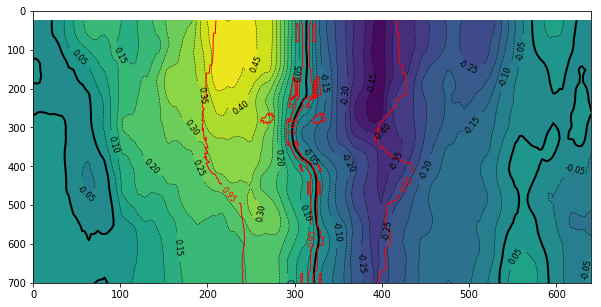

In [84]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,0)
plottools.PlotADCP(ax,atd/1000,depths,V_filt)
levels = [0.95]
cont = ax.contour(faisceau/1000,ZZ2,Rvals,colors='r',linewidths=1,levels=levels)
ax.clabel(cont, fontsize=8, inline=1, fmt='%1.2f')
plt.show()

In [7]:
## Select data within the threshold
indexes = inversions.SBRCindex(Rvals,atd,faisceau,depths,thresh=0.6)

/home/affholder/Documents/ENS/AFC/Stage/Araujo/Eddie_Tracks/Scripts/ADCP/inversions.py:272: RuntimeWarning: invalid value encountered in greater
  faisc = faisceau[i,Rvals[i,:] > thresh]


In [8]:
mask = np.zeros((V_filt.shape[0],V_filt.shape[1]))
mask[indexes] = 1
mask = mask == 1
V_filt_masked = np.ma.array(V_filt,mask=mask)
U_filt_masked = np.ma.array(U_filt,mask=mask)

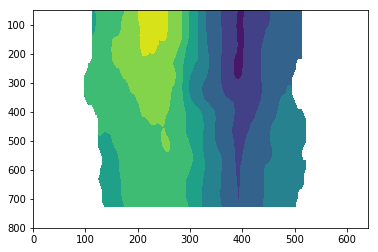

In [49]:
# XX,ZZ = np.meshgrid(atd_reg/1000,depths)
plt.ylim(800,50)
plt.contourf(XX,ZZ,np.transpose(V_filt_masked))
plt.show()

In [9]:
## Get the orientations of velocities to fit the best center
angles_m = np.angle(U_filt + V_filt*1j)
cos_m = np.cos(angles_m)
sin_m = np.sin(angles_m)
angles_m_msk = np.ma.array(angles_m,mask=mask)
cos_m_msk = np.ma.array(cos_m,mask=mask)
sin_m_msk = np.ma.array(sin_m,mask=mask)

In [10]:
## Mapping the error
xplore = np.arange(200,600,1)*1e3
yplore = np.arange(0,200,1)*1e3
Merr = inversions.MapError(xplore,yplore,x,y,cos_m[:,15],sin_m[:,15],mask=mask[:,15])

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


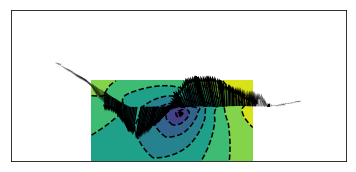

In [11]:
Xp,Yp = np.meshgrid(xplore,yplore)
M = np.transpose(Merr)
# plt.plot(x,y)
plt.contourf(Xp,Yp,M)
cont = plt.contour(Xp,Yp,M,linestyles='dashed',colors='k')
m.plot(Xp[M==np.nanmin(M)],Yp[M==np.nanmin(M)],'k*',ms=5)

m.quiver(x,y,U_filt_masked[:,15],V_filt_masked[:,3],pivot='tail',scale=5)
m.quiver(x,y,U_filt[:,15],V_filt[:,15],pivot='tail',alpha=0.5,scale=5)
plt.show()

In [12]:
Xvc = []
Yvc = []
deltat = 10
for i in range(len(depths)):
    vm = V_filt[:,i]
    if np.sum(np.isnan(vm)) == len(vm):
        xvc = np.nan
        yvc = np.nan
    else :
        vmint = np.nancumsum(vm)*deltat
        vc = np.nanmax(vmint)
        index = np.where(vmint == vc)[0]
        if len(index)>1:
            index = index[0]
        xvc = x[index]
        yvc = y[index]
    Xvc.append(xvc)
    Yvc.append(yvc)
Xvc = np.array(Xvc)
Yvc = np.array(Yvc)

In [13]:
Xc = []
Yc = []
Er = []
S = []
for i in range(len(depths)):
    msk = ~mask[:,i]
    res = sciopt.minimize(fun = inversions.AngularError,
                          x0=[Xvc[i],Yvc[i]],args=(x[msk],y[msk],cos_m[msk,i],sin_m[msk,i]),
                          method='Powell',tol=1e-8)
    xc = res['x'][0]
    yc = res['x'][1]
    rr = res['fun']
    s = res['success']
    Xc.append(xc)
    Yc.append(yc)
    Er.append(rr)
    S.append(s)
Xc = np.array(Xc)
Yc = np.array(Yc)
Er = np.array(Er)
S = np.array(S)
    

(0, 2000)

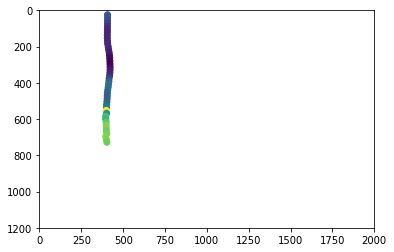

In [14]:
plt.scatter(Xc/1000,depths,c=Er)
plt.ylim(1200,0)
plt.xlim(0,2000)

In [56]:
## Now project everything on the cylinder

In [15]:
Ur = np.zeros((len(x),len(depths)))
Vr = np.zeros((len(x),len(depths)))
R = np.zeros((len(x),len(depths)))
R2 = np.zeros((len(x),len(depths)))
for i in range(len(depths)):
    xc = Xc[i]
    yc = Yc[i]
    if np.isfinite(xc):
        v = V_filt[:,i]
        u = U_filt[:,i]
        r = np.sqrt((x-xc)**2 + (y - yc)**2)
        s = np.sign(x-xc)
        s[s == 0] = 1
        r2 = s*np.sqrt((x-xc)**2 + (y - yc)**2)
        angles = np.angle((x - xc) + (y - yc)*1j,deg=False)
        num = np.isfinite(u)
        for j in range(len(angles)):
            if num[j]:
                theta = angles[j]
                uri,vri = level2.Rotation([u[j]],[v[j]],theta,[0,0])
            else:
                uri = np.nan
                vri = np.nan
            Ur[j,i] = uri
            Vr[j,i] = vri
    else:
        Ur[:,i] = np.full(len(angles),np.nan)
        Vr[:,i] = np.full(len(angles),np.nan)
    R[:,i] = r
    R2[:,i] = r2

#omegas = 

In [16]:
Zeta  = 2*np.angle(R + Vr*1j)

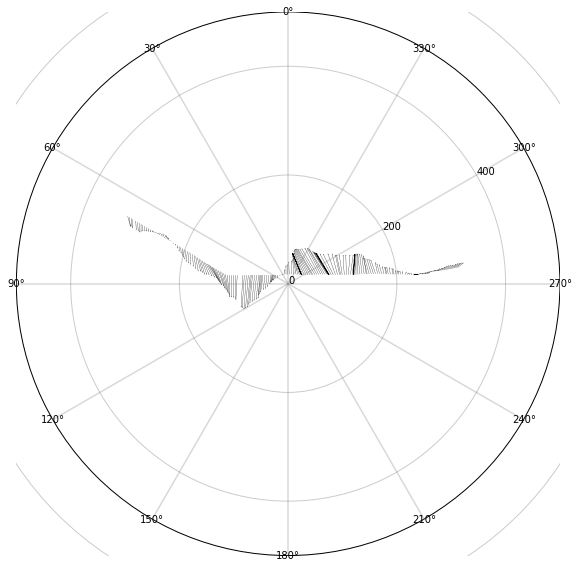

In [17]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
angles = np.angle((x - Xc[3]) + (y - Yc[3])*1j,deg=False)
plottools.Hodograph(ax,500,xtext=False,ytext=False,grid=200)
ax.quiver(R[:,5]/1000*np.cos(angles),R[:,5]/1000*np.sin(angles),U_filt[:,35],V_filt[:,35],scale=5,width=0.0005)
plt.show()

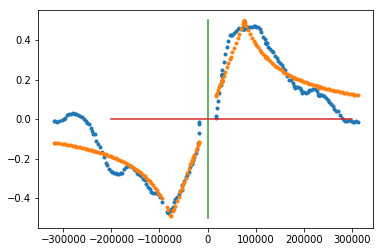

In [71]:
plt.plot(R2[:,5],V_filt[:,5],'.')
plt.plot(R2[:,5],Rankine(R2[:,5],rRs[5],rVs[5]),'.')

plt.plot([0,0],[-0.5,0.5])
plt.plot([-200e3,300e3],[0,0])

In [64]:
rRs = []
rVs = []
Errors = []
for i in range(len(depths)):
    r = R2[:,i]
    vm = V[:,i]
    rR0 = 75000
    rV0 = 0.5
    res = sciopt.minimize(fun = RankineErr,x0=(rR0,rV0),args=(r,vm),method='Powell',tol=1e-10)
    cf = res['x']
    err = res['fun']
    rRs.append(cf[0])
    rVs.append(cf[1])
    Errors.append(err)
Errors = np.array(Errors)
rRs = np.array(rRs)
rVs = np.array(rVs)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [65]:
sciopt.minimize(fun = RankineErr,x0=(rR0,rV0),args=(R[:,35],V[:,35]),method='Powell',tol=1e-10)

   direc: array([[1., 0.],
       [0., 1.]])
     fun: 1.0842850062286074
 message: 'Optimization terminated successfully.'
    nfev: 186
     nit: 2
  status: 0
 success: True
       x: array([5.14311976e+02, 5.00000061e-01])

(700, 0)

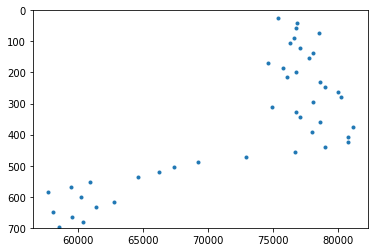

In [75]:
plt.plot(rRs,depths,'.')
plt.ylim(700,0)
#plt.xlim(0,1)

In [94]:
def foo(a):
    if a == 1:
        return(a)
    else:
        raise InputError("problem")

In [95]:
foo(2)

NameError: name 'InputError' is not defined